In [ ]:
### original code by Greg Henselman-Petrusek
### modified by Kushin Mukherjee

In [444]:
from fancyimpute import SoftImpute, BiScaler, IterativeSVD,MatrixFactorization
import numpy as np
import csv
import pandas as pd
import copy
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from joshiboyd import *
from scipy.io import loadmat
from scipy.stats import norm, zscore
from scipy import signal
import warnings
warnings.filterwarnings('ignore')



In [391]:
### set up some directory paths
proj_dir = os.path.abspath('../../')
data_dir = os.path.join(proj_dir, 'data')


In [450]:

def compute_d_prime(target, predicted):
    hits = np.sum((target == 1) & (predicted == 1))
    misses = np.sum((target == 1) & (predicted == 0))
    false_alarms = np.sum((target == 0) & (predicted == 1))
    correct_rejections = np.sum((target == 0) & (predicted == 0))
    
    n_hits = hits + 0.5
    n_false_alarms = false_alarms + 0.5
    n_trials = hits + misses + false_alarms + correct_rejections + 1
    
    HR = n_hits/(hits + misses)
    FAR = n_false_alarms / (false_alarms + correct_rejections)

    
    d_prime = norm.ppf(HR) - norm.ppf(FAR)

    
    return d_prime


### write a function to compute the jaccard-needham binary similarity between 2 boolean vectors

def jaccard_needham_similarity(x,y):
    x= x.astype(bool)
    y= y.astype(bool)
    """
    Computes the Jaccard-Needham similarity between two boolean vectors.
    """
    if np.sum(x) == 0 or np.sum(y) == 0:
        return 0
    else:
        return np.sum(x & y) / np.sum(x | y)
    
def k_highest_var_cols(M, k):
    col_vars = np.var(M, axis=0, ddof=0)
    sorted_cols = np.argsort(col_vars)[::-1] # Sort descending
    return sorted_cols[:k]

In [5]:
### read in the norm data

animal_fn = os.path.join(data_dir, 'LeuvenNorms/ANIMALSexemplarfeaturesbig.txt')
animal_df = pd.read_csv(animal_fn, sep='\t', header=0, index_col=0).reset_index().drop('FFrq',axis=1)
animal_df = animal_df.rename(columns={'feature/_exemplar_ENGLISH':'Item'})

tool_fn = os.path.join(data_dir, 'LeuvenNorms/ARTIFACTSexemplarfeaturesbig.txt')
### read in the file ARTIFACTSexemplarfeaturesbig.txt as a data frame and prevent the utf-8 encoding error
tool_df = pd.read_csv(tool_fn, sep='\t', header=0, index_col=0, encoding='latin-1').reset_index().drop('FFrq',axis=1)

print(f'We have {tool_df.shape[1]+animal_df.shape[1]-2} concepts in total')


flan_df = pd.read_csv(os.path.join(data_dir,'flan_leuven_norms_overlap.csv'))

## stack animal_df dataframe and tool_df dataframe vertically making sure that common column names are shared between the two dataframes
animals = animal_df.columns[1:]
tools = tool_df.columns[1:]
merged_df = pd.merge(animal_df, tool_df, on='Item', how='outer')
leuven_concept_order = merged_df.columns[1:]


We have 295 concepts in total


In [964]:
concept_sort_order = merged_df.columns.values


# make all the values in column 'concept' lower case
flan_df['concept'] = flan_df['concept'].str.lower()
flan_df=flan_df.sort_values(by='concept',key=lambda x: pd.Series(x).map(dict(zip(concept_sort_order, range(len(concept_sort_order))))))
feature_order = merged_df.Item.values
flan_df = flan_df[['concept']+list(feature_order)]
full_feat_array_flan = np.array(flan_df.iloc[:,1:]).astype(np.float)
full_feat_array_flan.shape

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_6108/3770812752.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_feat_array_flan = np.array(flan_df.iloc[:,1:]).astype(np.float)


(295, 2026)

In [965]:
# ###  set the index of tmp_df to be the column Item then sort the columns of tmp_df by in alphabetical order 
# tmp_df = tmp_df.set_index('Item').T.sort_index().T
# ### change all the column names in tmp_df to lower case and sort them alphabetically
# tmp_df.columns = tmp_df.columns.str.lower()
# tmp_df = tmp_df.sort_index(axis=1)
# tmp_df = tmp_df.reset_index()


In [966]:
full_feat_array  = np.array(merged_df)[:,1:].T
full_feat_array = full_feat_array.astype(float)
full_feat_array = np.nan_to_num(full_feat_array, nan=0)
full_feat_array.shape

(295, 2026)

In [967]:
# ### concert dataframes to arrays and store the column names
# animals = animal_df.columns[1:]
# tools = tool_df.columns[1:]

# animal_array = np.array(animal_df)[:,1:].T
# tool_array = np.array(tool_df)[:,1:].T



In [968]:
# ### glom animal and tool arrays together and set max value to 1
# full_feat_array = np.vstack([np.hstack([animal_array,np.zeros((animal_array.shape[0],tool_array.shape[1]))])\
#                     ,np.hstack([np.zeros((tool_array.shape[0],animal_array.shape[1])),tool_array])]).astype(np.float)


full_feat_array[full_feat_array<4] =0 
full_feat_array[full_feat_array>1] =1 


full_feat_array = np.nan_to_num(full_feat_array,nan=0)

full_concept_list = np.hstack([animals,tools])
(d1, d2) = full_feat_array.shape

distmat = pairwise_distances(full_feat_array, metric='cosine')
distman_flan = pairwise_distances(full_feat_array_flan, metric='cosine')

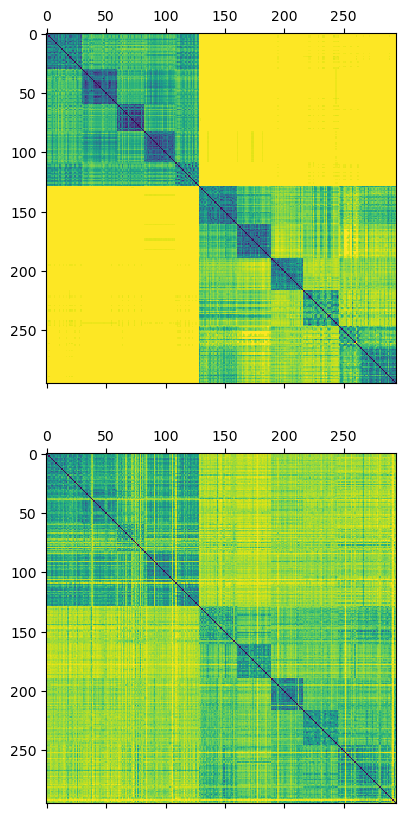

In [969]:
## let's look at our data
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].matshow(distmat)
### add the strings in full_concept_list as the x and y ticks
# axes[0].set_xticks(range(len(full_concept_list)), full_concept_list, rotation=90)
# axes[0].set_yticks(range(len(full_concept_list)), full_concept_list)

axes[1].matshow(distman_flan)
plt.show()

Text(0.5, 1.0, 'human_data')

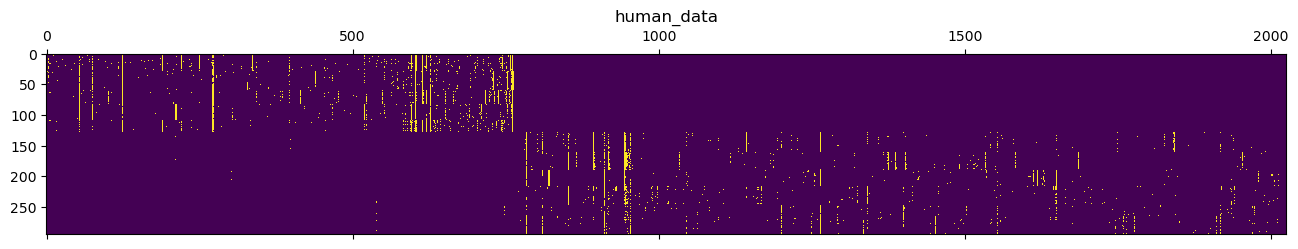

In [970]:
### original matrix
plt.matshow(full_feat_array)
plt.title('human_data')

Text(0.5, 1.0, 'flan')

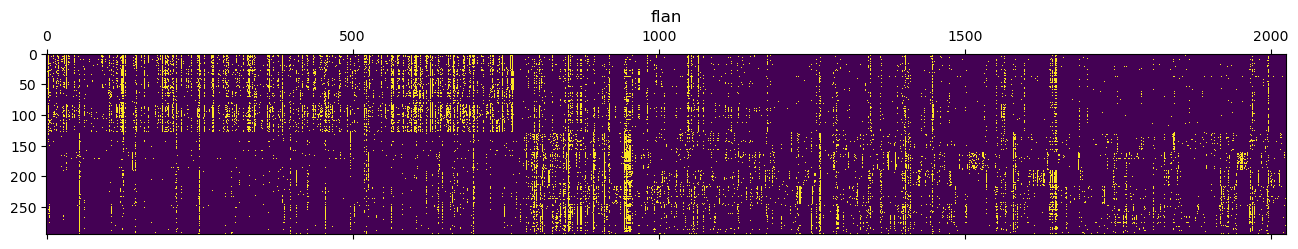

In [971]:
plt.matshow(full_feat_array_flan)
plt.title('flan')

In [972]:
leuven_animal_array = full_feat_array[:129,:764]
leuven_tool_array = full_feat_array[129:,764:]

flan_animal_array = full_feat_array_flan[:129,:764]
flan_tool_array = full_feat_array_flan[129:,764:]


### Binary Matrix Completion Demo

In [973]:
## Let's walk through the matrix completion process

full_feat_array = full_feat_array.astype(float)
# dropped_array = copy.deepcopy(full_feat_array)
dropped_array = copy.deepcopy(full_feat_array)
dropped_positive_count = 0
dropped_negative_count = 0
d1,d2 = dropped_array.shape

#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1       

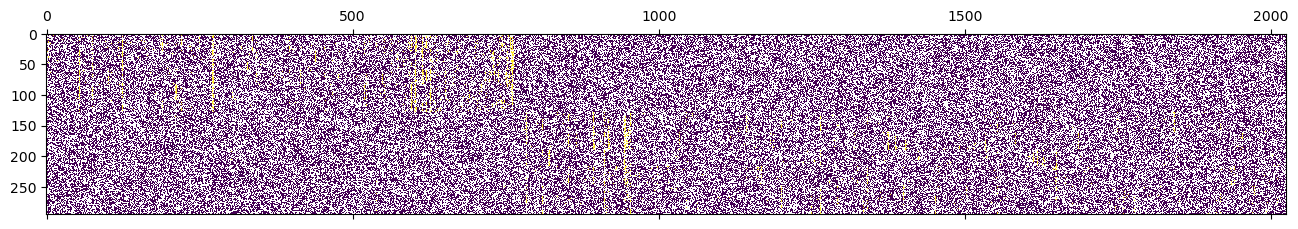

In [974]:
### imputed matrix
plt.matshow(dropped_array)

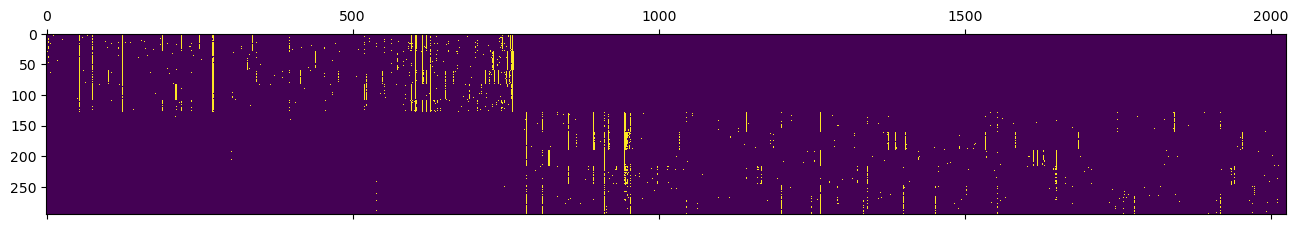

In [975]:
### reconstruct matrix
rank = 10
filled_array = IterativeSVD(min_value=0, max_value=1,rank=rank,verbose=False).fit_transform(dropped_array)
filled_array = np.round(filled_array)
plt.matshow(filled_array)


In [976]:
cors=[]
for i in range(filled_array.shape[0]):
    cors.append(np.corrcoef(filled_array[i,:],full_feat_array[i,:])[0,1])
print(f'mean reconstruction correlation using matrix completion with rank {rank} is {np.mean(np.nan_to_num(cors, nan=0))}')

mean reconstruction correlation using matrix completion with rank 10 is 0.8391212739569415


 Run entire matrix reconstruction process for different degrees of noise and for different ranks of matrices

In [531]:
cors=[]
ranks=[]
noise=[]
for i in np.arange(0.1,1,step=.1):
    dropped_array = copy.deepcopy(full_feat_array)
    dropped_positive_count = 0
    dropped_negative_count = 0


    #    Choose dropout parameters
    #   -------------------------

    p_droptruepos   =   i # probability of dropping a true positive value
    p_droptrueneg   =   i # probability of dropping a true negative (zero) value


    #   Replace some entries with NaN's
    #   -------------------------------

    for row in range(d1):
        for col in range(d2):
            if dropped_array[row][col] == 1:
                if np.random.uniform(0,1) < p_droptruepos:
                    dropped_array[row][col] = np.NaN
                    dropped_positive_count +=1
            else:
                if np.random.uniform(0, 1) < p_droptrueneg:
                    dropped_array[row][col] = np.NaN
                    dropped_negative_count +=1       

    for rank in range(1,30):
        filled_array = IterativeSVD(min_value=0, max_value=1,rank=rank,verbose=False).fit_transform(dropped_array)
        filled_array = np.round(filled_array)

        for j in range(filled_array.shape[0]):
            cors.append(np.corrcoef(filled_array[j,:],full_feat_array[j,:])[0,1])
            ranks.append(rank)
            noise.append(i)

            

KeyboardInterrupt: 

In [26]:
recon_df = pd.DataFrame({'corr':cors,'rank':ranks,'noise':noise})

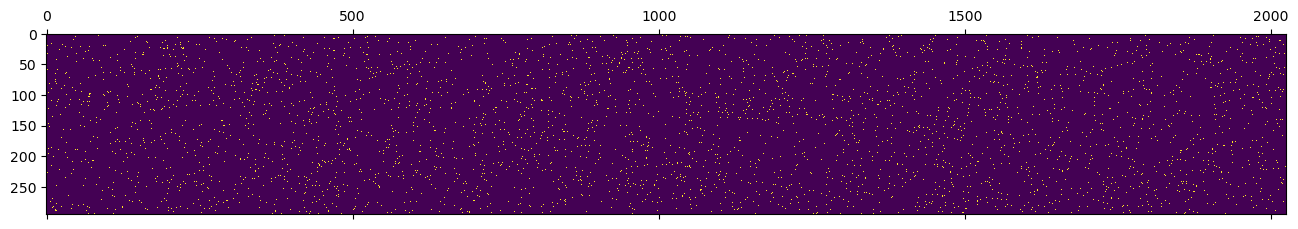

In [27]:
### generate a control matrix of shuffled values to compare to the reconstructed matrix
np.random.seed(42)
dropped_array = copy.deepcopy(full_feat_array)

## go column by column in dropped_array and shuffle the rows in each column independently then go row by row and shuffle the columns in each row independently and return a new matrix called dropped_array_shuffled
for col in range(dropped_array.shape[1]):
    dropped_array[:,col] = np.random.permutation(dropped_array[:,col])

for row in range(dropped_array.shape[0]):
    dropped_array[row,:] = np.random.permutation(dropped_array[row,:])

plt.matshow(dropped_array)

shuffled_cors=[]
tru_cors = []
shuffled_ranks=[]
for rank in range(1,30):
    u,s,v = np.linalg.svd(dropped_array, full_matrices=False)
    u_tru, s_tru, v_tru = np.linalg.svd(full_feat_array, full_matrices=False)
    # s[rank:] = 0
    filled_array = u[:,:rank]@(np.diag(s[:rank])@v[:rank,:])
    filled_array = np.round(filled_array)

    filled_array_tru = u_tru[:,:rank]@(np.diag(s_tru[:rank])@v_tru[:rank,:])
    filled_array_tru = np.round(filled_array_tru)
    for j in range(filled_array.shape[0]):
        shuffled_cors.append(np.corrcoef(filled_array[j,:],full_feat_array[j,:])[0,1])
        tru_cors.append(np.corrcoef(filled_array_tru[j,:],full_feat_array[j,:])[0,1])
        shuffled_ranks.append(rank)

    
   



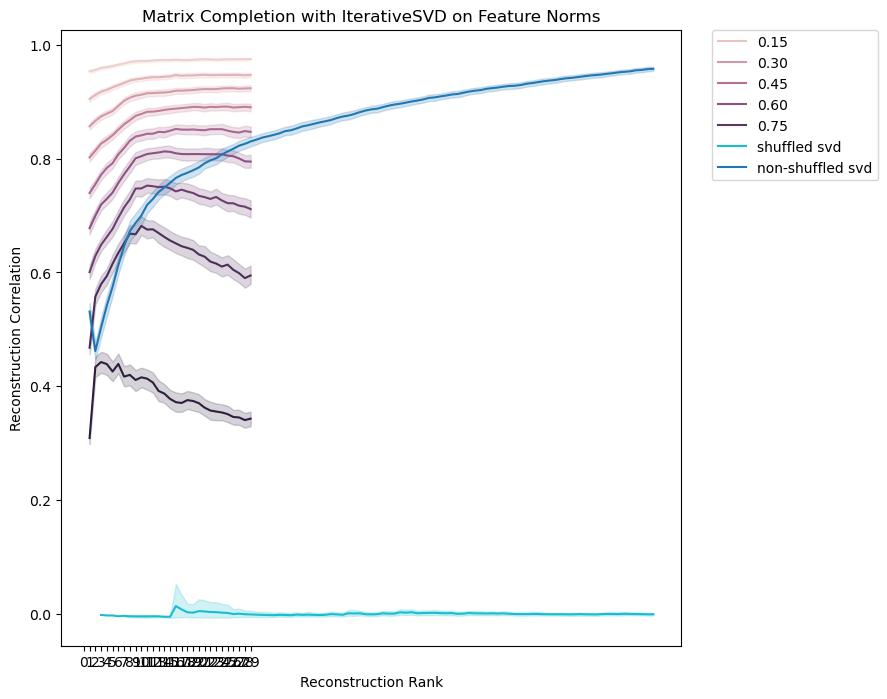

In [28]:
### plot things!

plt.figure(figsize=(8,8))
sns.lineplot(x='rank',y='corr',hue='noise',data=recon_df)
plt.xticks(np.arange(0,30,step=1))
#make a lineplot of the shuffled correlations
sns.lineplot(x=shuffled_ranks,y=shuffled_cors, errorbar=('ci', 95),label='shuffled svd')
sns.lineplot(x=shuffled_ranks,y=tru_cors, errorbar=('ci', 95),label='non-shuffled svd')
plt.ylabel('Reconstruction Correlation')
plt.xlabel('Reconstruction Rank')
plt.legend(title='noise')
plt.title('Matrix Completion with IterativeSVD on Feature Norms')
## place legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [29]:
tru_cors[-1]

1.0

In [30]:
cors=[]
ranks=[]
noise=[]
for i in np.arange(0.1,1,step=.1):
    dropped_array = copy.deepcopy(full_feat_array)
    dropped_positive_count = 0
    dropped_negative_count = 0


    #    Choose dropout parameters
    #   -------------------------

    p_droptruepos   =   i # probability of dropping a true positive value
    p_droptrueneg   =   .5 # probability of dropping a true negative (zero) value


    #   Replace some entries with NaN's
    #   -------------------------------

    for row in range(d1):
        for col in range(d2):
            if dropped_array[row][col] == 1:
                if np.random.uniform(0,1) < p_droptruepos:
                    dropped_array[row][col] = np.NaN
                    dropped_positive_count +=1
            else:
                if np.random.uniform(0, 1) < p_droptrueneg:
                    dropped_array[row][col] = np.NaN
                    dropped_negative_count +=1       

    for rank in range(1,30):
        filled_array = IterativeSVD(min_value=0, max_value=1,rank=rank,verbose=False).fit_transform(dropped_array)
        filled_array = np.round(filled_array)

        for j in range(filled_array.shape[0]):
            cors.append(np.corrcoef(filled_array[j,:],full_feat_array[j,:])[0,1])
            ranks.append(rank)
            noise.append(i)
recon_df_pos = pd.DataFrame({'corr':cors,'rank':ranks,'noise':noise})




cors=[]
ranks=[]
noise=[]
for i in np.arange(0.1,1,step=.1):
    dropped_array = copy.deepcopy(full_feat_array)
    dropped_positive_count = 0
    dropped_negative_count = 0


    #    Choose dropout parameters
    #   -------------------------

    p_droptruepos   =   .5 # probability of dropping a true positive value
    p_droptrueneg   =   i # probability of dropping a true negative (zero) value


    #   Replace some entries with NaN's
    #   -------------------------------

    for row in range(d1):
        for col in range(d2):
            if dropped_array[row][col] == 1:
                if np.random.uniform(0,1) < p_droptruepos:
                    dropped_array[row][col] = np.NaN
                    dropped_positive_count +=1
            else:
                if np.random.uniform(0, 1) < p_droptrueneg:
                    dropped_array[row][col] = np.NaN
                    dropped_negative_count +=1       

    for rank in range(1,30):
        filled_array = IterativeSVD(min_value=0, max_value=1,rank=rank,verbose=False).fit_transform(dropped_array)
        filled_array = np.round(filled_array)

        for j in range(filled_array.shape[0]):
            cors.append(np.corrcoef(filled_array[j,:],full_feat_array[j,:])[0,1])
            ranks.append(rank)
            noise.append(i)
recon_df_neg = pd.DataFrame({'corr':cors,'rank':ranks,'noise':noise})
            

KeyboardInterrupt: 

In [ ]:
### plot things!

plt.figure(figsize=(8,8))
sns.lineplot(x='rank',y='corr',hue='noise',data=recon_df_pos)
plt.xticks(np.arange(0,30,step=1))

## place legend outside of plot


sns.lineplot(x='rank',y='corr',hue='noise', data=recon_df_neg, linestyle='--')

plt.xticks(np.arange(0,30,step=1))

plt.ylabel('Reconstruction Correlation')
plt.xlabel('Reconstruction Rank')
plt.legend(title='noise')
plt.title('Matrix Completion with IterativeSVD on Feature Norms')







## place legend outside of plot
plt.show()

### Flan comparisons

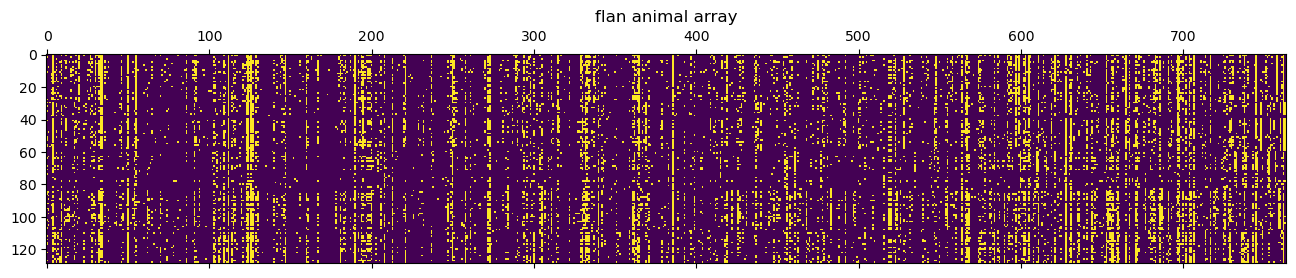

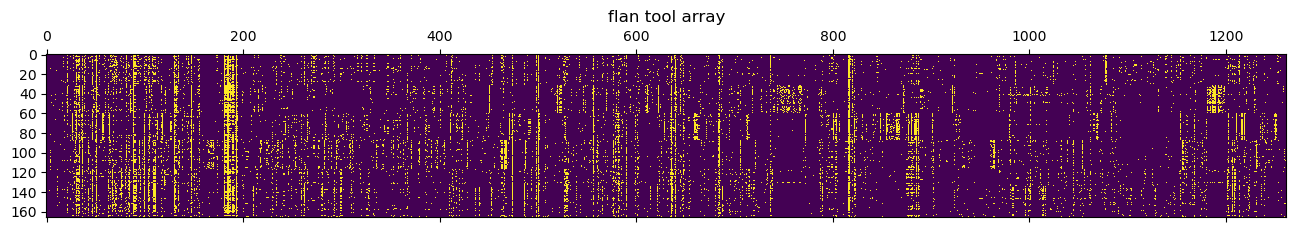

In [977]:
plt.matshow(flan_animal_array)
plt.title('flan animal array')
plt.show()
plt.matshow(flan_tool_array)
plt.title('flan tool array')
plt.show()


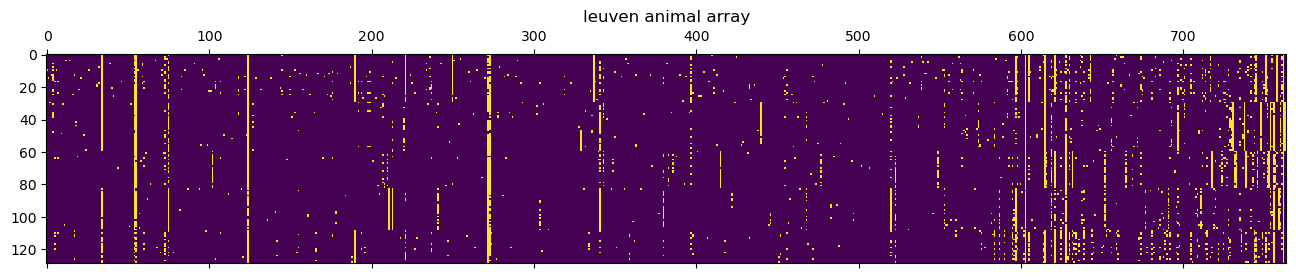

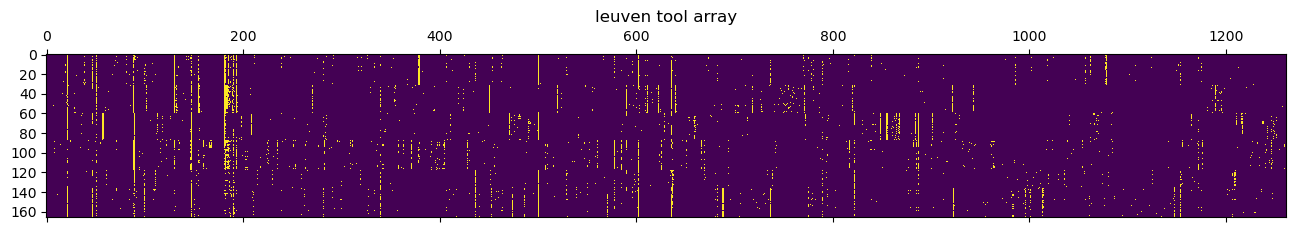

In [978]:
plt.matshow(leuven_animal_array)
plt.title('leuven animal array')
plt.show()
plt.matshow(leuven_tool_array)
plt.title('leuven tool array')
plt.show()

#### Matrix reconstruction on FLAN data for animals

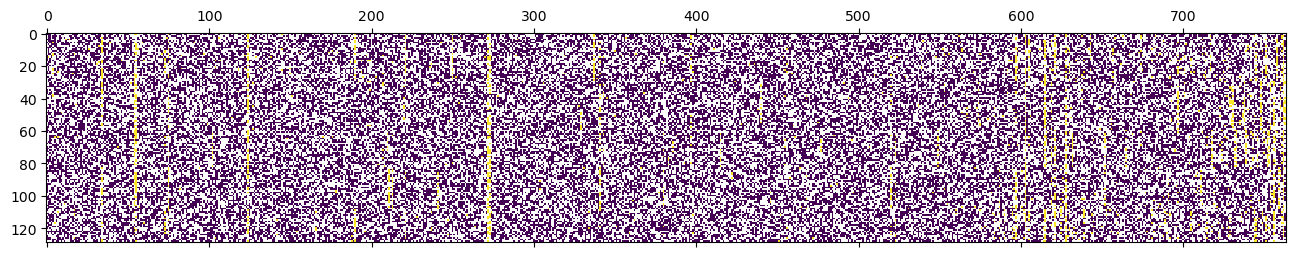

In [979]:
## Let's walk through the matrix completion process


dropped_array = copy.deepcopy(leuven_animal_array)
dropped_positive_count = 0
dropped_negative_count = 0
d1,d2 = dropped_array.shape

#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.50 # probability of dropping a true positive value
p_droptrueneg   =   0.50 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1       



### imputed matrix
plt.matshow(dropped_array)

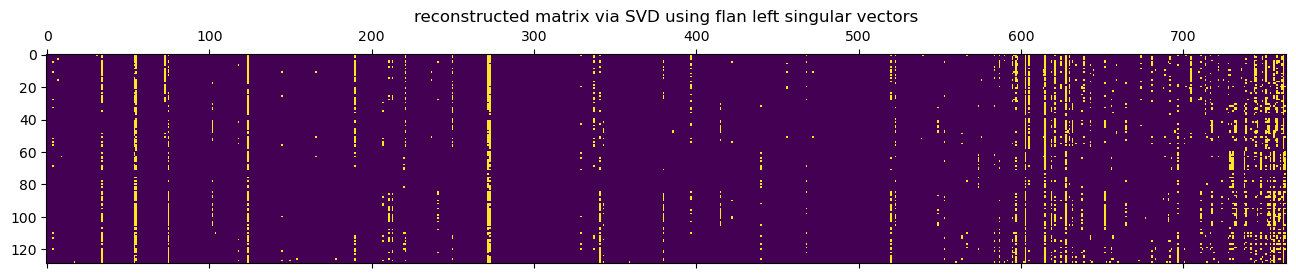

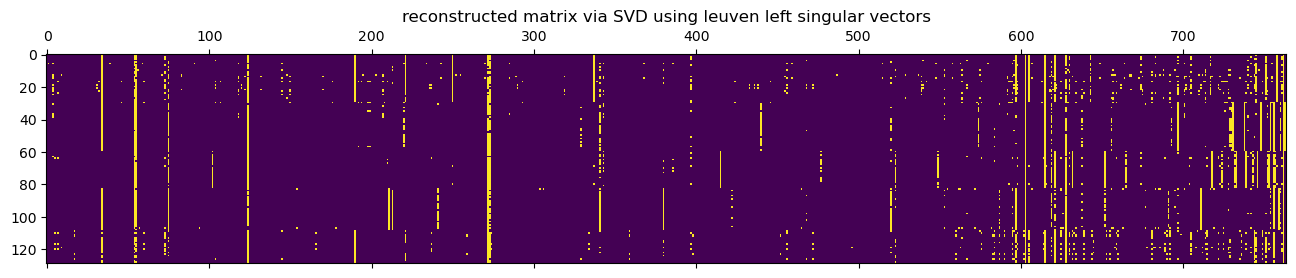

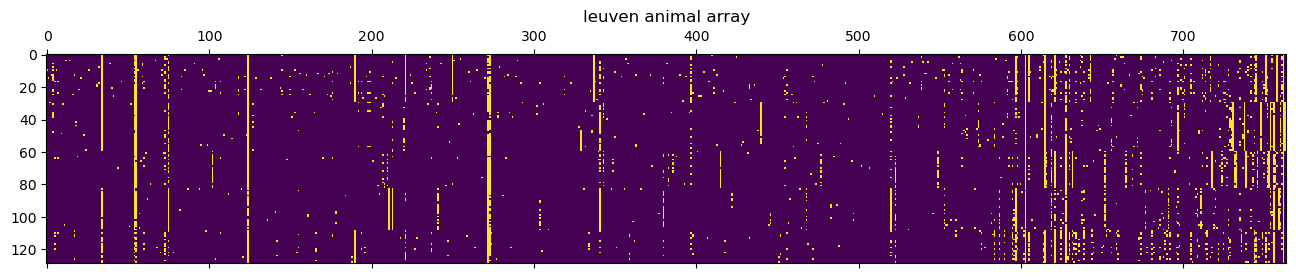

In [980]:
### reconstruct matrix
rank=15
filled_array = IterativeSVD(min_value=0, max_value=1,rank=50,verbose=False).fit_transform(dropped_array)
u,s,v = np.linalg.svd(filled_array, full_matrices=False)
u_,s_,v_ = np.linalg.svd(flan_animal_array, full_matrices=False)
# s[rank:] = 0
filled_array_svd = u_[:,:rank]@(np.diag(s[:rank])@v[:rank,:])
filled_array_baseline = u[:,:rank]@(np.diag(s[:rank])@v[:rank,:])
filled_array_svd = np.round(filled_array_svd)
filled_array_svd = np.clip(filled_array_svd,0,1)
filled_array_baseline = np.round(filled_array_baseline)
filled_array_baseline = np.clip(filled_array_baseline,0,1)



plt.matshow(filled_array_svd)
plt.title('reconstructed matrix via SVD using flan left singular vectors')
plt.show()
plt.matshow(filled_array_baseline)
plt.title('reconstructed matrix via SVD using leuven left singular vectors')
plt.matshow(leuven_animal_array)
plt.title('leuven animal array')
plt.show()


In [981]:
cors=[]
dprimes=[]
matches=[]
jn_sims=[]

for i in range(leuven_animal_array.shape[0]):
    cors.append(np.corrcoef(leuven_animal_array[i,:],flan_animal_array[i,:])[0,1])
    dprimes.append(compute_d_prime(leuven_animal_array[i,:],flan_animal_array[i,:]))
    matches.append(np.sum(leuven_animal_array[i,:]==flan_animal_array[i,:]))
    jn_sims.append(jaccard_needham_similarity(leuven_animal_array[i,:],flan_animal_array[i,:]))
    
print(f'animal correlation without matrix completion: {np.mean(np.nan_to_num(cors,nan=0))}')
print(f'animal dprime without matrix completion: {np.mean(np.nan_to_num(dprimes,nan=0))}')
print(f'animal matches without matrix completion: {np.sum(matches)/(leuven_animal_array.shape[0]*leuven_animal_array.shape[1])}')
print(f'animal jn similarity without matrix completion: {np.mean(np.nan_to_num(jn_sims,nan=0))}')

animal correlation without matrix completion: 0.27264731893874566
animal dprime without matrix completion: 1.4587320268679007
animal matches without matrix completion: 0.8631133568732497
animal jn similarity without matrix completion: 0.16141854453656243


In [982]:
cors_mc=[]
dprimes_mc=[]
matches_mc=[]
jn_sims_mc=[]

for i in range(leuven_animal_array.shape[0]):
    cors_mc.append(np.corrcoef(leuven_animal_array[i,:],filled_array_svd[i,:])[0,1])
    dprimes_mc.append(compute_d_prime(leuven_animal_array[i,:],filled_array_svd[i,:]))
    matches_mc.append(np.sum(leuven_animal_array[i,:]==filled_array_svd[i,:]))
    jn_sims_mc.append(jaccard_needham_similarity(leuven_animal_array[i,:],filled_array_svd[i,:]))

print(f'animal correlation with rank {rank} matrix completion: {np.mean(np.nan_to_num(cors_mc, nan=0))}')
print(f'animal dprime with rank {rank} matrix completion: {np.mean(np.nan_to_num(dprimes_mc, nan=0))}')
print(f'animal matches with rank {rank} matrix completion: {np.sum(matches_mc)/(leuven_animal_array.shape[0]*leuven_animal_array.shape[1])}')
print(f'animal jn similarity with rank {rank} matrix completion: {np.mean(np.nan_to_num(jn_sims_mc, nan=0))}')




animal correlation with rank 15 matrix completion: 0.3739853372894123
animal dprime with rank 15 matrix completion: 1.814288216936753
animal matches with rank 15 matrix completion: 0.9545639027557936
animal jn similarity with rank 15 matrix completion: 0.25414430436442464


/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_bas

In [983]:
cors_mc=[]
dprimes_mc=[]
matches_mc=[]
jn_sims_mc=[]

for i in range(leuven_animal_array.shape[0]):
    cors_mc.append(np.corrcoef(leuven_animal_array[i,:],filled_array_baseline[i,:])[0,1])
    dprimes_mc.append(compute_d_prime(leuven_animal_array[i,:],filled_array_baseline[i,:]))
    matches_mc.append(np.sum(leuven_animal_array[i,:]==filled_array_baseline[i,:]))
    jn_sims_mc.append(jaccard_needham_similarity(leuven_animal_array[i,:],filled_array_baseline[i,:]))

print(f'animal correlation with rank {rank} matrix completion: {np.mean(np.nan_to_num(cors_mc, nan=0))}')
print(f'animal dprime with rank {rank} matrix completion: {np.mean(np.nan_to_num(dprimes_mc, nan=0))}')
print(f'animal matches with rank {rank} matrix completion: {np.sum(matches_mc)/(leuven_animal_array.shape[0]*leuven_animal_array.shape[1])}')
print(f'animal jn similarity with rank {rank} matrix completion: {np.mean(np.nan_to_num(jn_sims_mc, nan=0))}')




animal correlation with rank 15 matrix completion: 0.8010455621236283
animal dprime with rank 15 matrix completion: 3.438007182056547
animal matches with rank 15 matrix completion: 0.9834205933682374
animal jn similarity with rank 15 matrix completion: 0.6838587562668462


#### Matrix reconstruction on FLAN data for tools

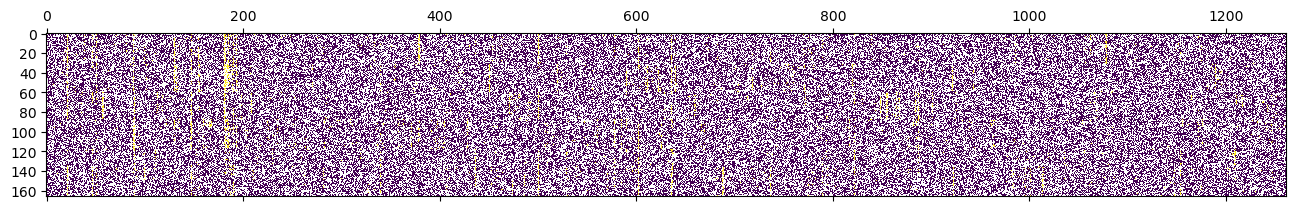

In [984]:
## Let's walk through the matrix completion process


dropped_array = copy.deepcopy(leuven_tool_array)
dropped_positive_count = 0
dropped_negative_count = 0
d1,d2 = dropped_array.shape

#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1       



### imputed matrix
plt.matshow(dropped_array)

Text(0.5, 1.0, 'reconstructed matrix via SVD')

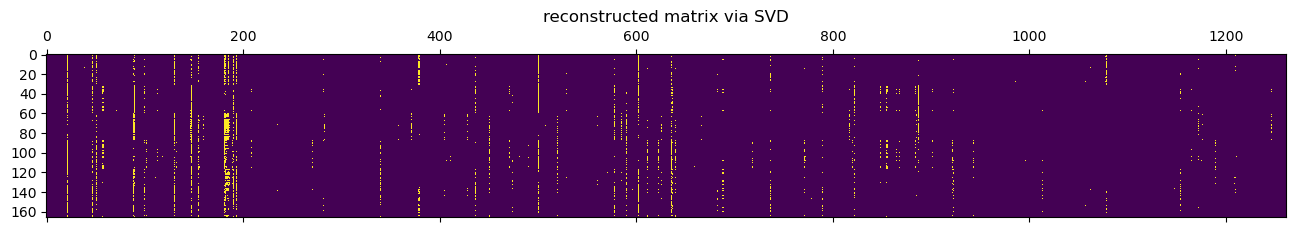

In [985]:
### reconstruct matrix
rank=15

u,s,v = np.linalg.svd(leuven_tool_array, full_matrices=False)
u_,s_,v_ = np.linalg.svd(flan_tool_array, full_matrices=False)
# s[rank:] = 0
filled_array = u_[:,:rank]@(np.diag(s[:rank])@v[:rank,:])
filled_array_svd = np.round(filled_array)
filled_array_svd = np.clip(filled_array_svd,0,1)



filled_array = IterativeSVD(min_value=0, max_value=1,rank=rank,verbose=False).fit_transform(dropped_array)
filled_array = np.round(filled_array)
plt.matshow(filled_array_svd)
plt.title('reconstructed matrix via SVD')

In [986]:
cors=[]
dprimes=[]
matches = []
jn_sims = []

for i in range(leuven_animal_array.shape[0]):
    cors.append(np.corrcoef(leuven_tool_array[i,:],flan_tool_array[i,:])[0,1])
    dprimes.append(compute_d_prime(leuven_tool_array[i,:],flan_tool_array[i,:]))
    matches.append(np.sum(leuven_tool_array[i,:]==flan_tool_array[i,:]))
    jn_sims.append(jaccard_needham_similarity(leuven_tool_array[i,:],flan_tool_array[i,:]))

print(f'tool correlation without matrix completion: {np.mean(np.nan_to_num(cors,nan=0))}')
print(f'tool dprime without matrix completion: {np.mean(np.nan_to_num(dprimes,nan=0))}')
print(f'tool matches without matrix completion: {np.sum(matches)/(leuven_tool_array.shape[0]*leuven_tool_array.shape[1])}')
print(f'tool jn similarity without matrix completion: {np.mean(np.nan_to_num(jn_sims,nan=0))}')


tool correlation without matrix completion: 0.3220897996462487
tool dprime without matrix completion: 1.9553323788097396
tool matches without matrix completion: 0.7207912473984687
tool jn similarity without matrix completion: 0.17618227075630008


In [987]:
cors=[]
dprimes=[]
matches = []
jn_sims = []

for i in range(leuven_animal_array.shape[0]):
    cors.append(np.corrcoef(leuven_tool_array[i,:],filled_array_svd[i,:])[0,1])
    dprimes.append(compute_d_prime(leuven_tool_array[i,:],filled_array_svd[i,:]))
    matches.append(np.sum(leuven_tool_array[i,:]==filled_array_svd[i,:]))
    jn_sims.append(jaccard_needham_similarity(leuven_tool_array[i,:],filled_array_svd[i,:]))

print(f'tool correlation with rank {rank} matrix completion: {np.mean(np.nan_to_num(cors, nan=0))}')
print(f'tool dprime with rank {rank} matrix completion: {np.mean(np.nan_to_num(dprimes, nan=0))}')
print(f'tool matches with rank {rank} matrix completion: {np.sum(matches)/(leuven_tool_array.shape[0]*leuven_tool_array.shape[1])}')
print(f'tool jn similarity with rank {rank} matrix completion: {np.mean(np.nan_to_num(jn_sims, nan=0))}')



tool correlation with rank 15 matrix completion: 0.23439522550945163
tool dprime with rank 15 matrix completion: 1.5100534747529766
tool matches with rank 15 matrix completion: 0.7546541156702882
tool jn similarity with rank 15 matrix completion: 0.14892100208381862


/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/numpy/lib/function_bas

### New Concept Estimation

#### animals

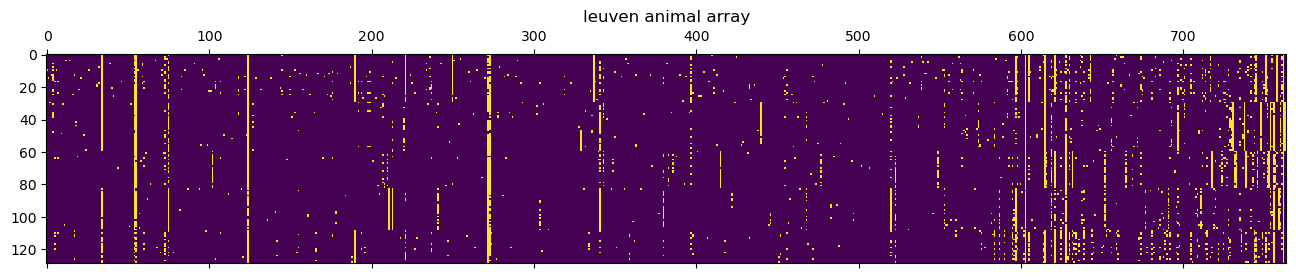

In [988]:
animal_test_arr = leuven_animal_array[:-1,:]
plt.matshow(leuven_animal_array)
plt.title('leuven animal array')
plt.show()

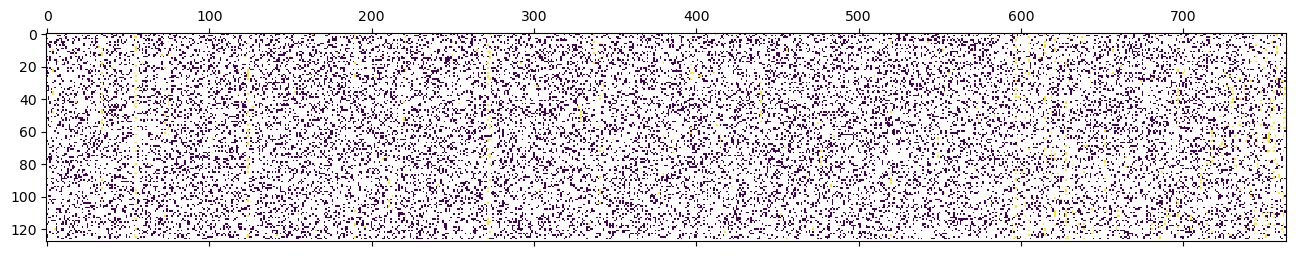

In [989]:
### add noise to groundtruth matrix

np.random.seed(300)
leuven_animal_array_copy = copy.deepcopy(animal_test_arr)
d1,d2 = leuven_animal_array_copy.shape

#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.8 # probability of dropping a true positive value
p_droptrueneg   =   0.8 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if leuven_animal_array_copy[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                leuven_animal_array_copy[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                leuven_animal_array_copy[row][col] = np.NaN
                dropped_negative_count +=1       


leuven_animal_array_copy[-1,:]= np.NaN
### imputed matrix
plt.matshow(leuven_animal_array_copy)

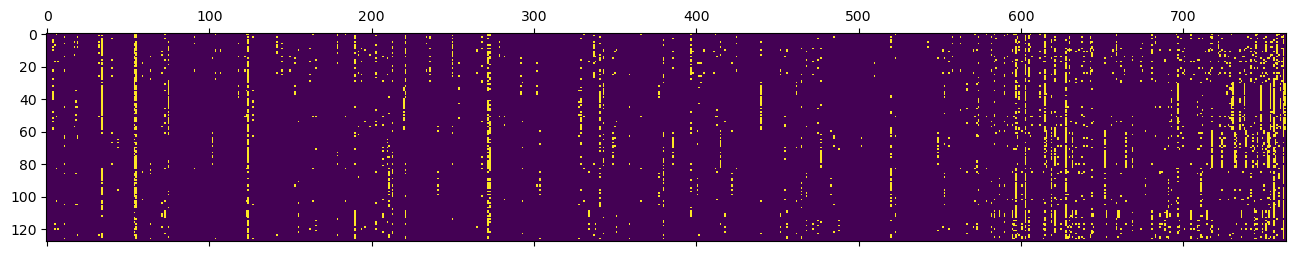

In [990]:
### approximate matrix using iterativeSVD

leuven_animal_array_recon = IterativeSVD(min_value=0, max_value=1,rank=30,verbose=False).fit_transform(leuven_animal_array_copy)
leuven_animal_array_recon = np.round(leuven_animal_array_recon)
plt.matshow(leuven_animal_array_recon)



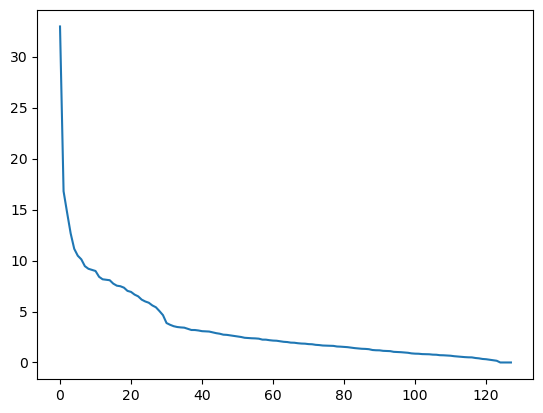

In [991]:

animal_u, animal_s, animal_v = np.linalg.svd(leuven_animal_array_recon, full_matrices=False) ### do svd on the approx matrix
## matrix multiply animal_s with animal_v
animal_basis = np.diag(animal_s)@animal_v


### get the 20 columns with highest variance
test_cols = k_highest_var_cols(leuven_animal_array_recon,60)

plt.plot(np.arange(animal_s.shape[0]),animal_s)

#### loop through all animals and get an average estimate of the quality of predictions

In [1012]:

from sklearn import linear_model as lm
np.random.seed(42)
from tqdm import tqdm, trange

matrix_completion_dprimes=[]
baseline_flan_dprimes=[]
pred_vecs=[]
rank=15
for i in trange(leuven_animal_array.shape[0]):
    target_concept = leuven_animal_array[i,:] ### the concept to predict
    observed_array = np.delete(leuven_animal_array,i,axis=0) ### the array with the concept removed

    observed_array_copy = copy.deepcopy(observed_array)
    d1,d2 = observed_array_copy.shape

    #    Choose dropout parameters
    #   -------------------------

    p_droptruepos   =   0.8 # probability of dropping a true positive value
    p_droptrueneg   =   0.8 # probability of dropping a true negative (zero) value

    #   Replace some entries with NaN's
    #   -------------------------------

    for row in range(d1):
        for col in range(d2):
            if observed_array_copy[row][col] == 1:
                if np.random.uniform(0,1) < p_droptruepos:
                    observed_array_copy[row][col] = np.NaN
               
            else:
                if np.random.uniform(0, 1) < p_droptrueneg:
                    observed_array_copy[row][col] = np.NaN
    
    ### approximate matrix using iterativeSVD
    isvd_obj = IterativeSVD(min_value=0, max_value=1,rank=50,verbose=False)
    observed_array_approx = isvd_obj.fit_transform(observed_array_copy)
    observed_array_approx = np.round(observed_array_approx)


    animal_u, animal_s, animal_v = np.linalg.svd(observed_array_approx, full_matrices=False) ### do svd on the approx matrix
    ## matrix multiply animal_s with animal_v
    animal_basis = np.diag(animal_s)@animal_v

    ### get the k columns with highest variance
    test_cols = k_highest_var_cols(leuven_animal_array_recon,100)
                    
    ### use logistic regression to predict the target concept left singular vector from flan answwers
    if  np.sum(flan_animal_array[i,test_cols])==0:
       reg = lm.LogisticRegression(fit_intercept=True).fit(animal_basis.T[:,:rank],flan_animal_array[i,:])
    else:
        reg = lm.LogisticRegression(fit_intercept=True).fit(animal_basis.T[test_cols,:rank],flan_animal_array[i,test_cols])
    pred_animal_u_vec = reg.coef_
    pred_vec = np.clip(np.round(pred_animal_u_vec@animal_basis[:rank,:]),0,1)
    pred_vecs.append(pred_vec)
    matrix_completion_dprimes.append(compute_d_prime(target_concept,pred_vec))
    baseline_flan_dprimes.append(compute_d_prime(target_concept,flan_animal_array[i,:]))


 20%|██        | 26/129 [00:34<02:18,  1.34s/it]

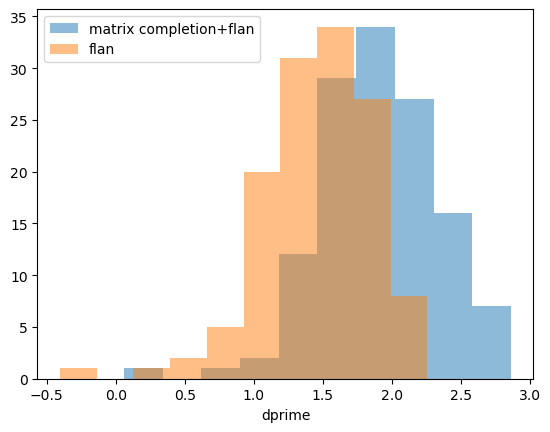

In [ ]:
plt.hist(matrix_completion_dprimes, label='matrix completion+flan', alpha=0.5)
plt.hist(baseline_flan_dprimes,label='flan', alpha=0.5)
plt.xlabel('dprime')
plt.legend()
plt.show()


In [ ]:
### do a t-test to see if matrix completion is better than flan
from scipy import stats
stats.ttest_ind(matrix_completion_dprimes,baseline_flan_dprimes)


Ttest_indResult(statistic=8.701632131552806, pvalue=4.063255424741998e-16)

In [ ]:
recon_animal_array= np.vstack(pred_vecs)

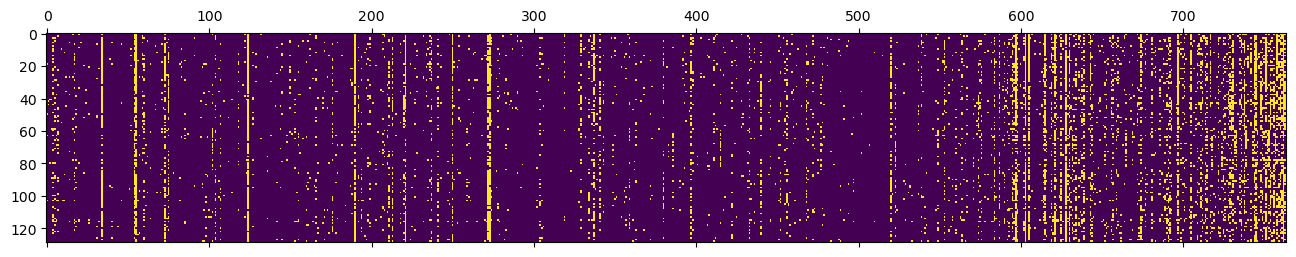

In [ ]:
plt.matshow(recon_animal_array)

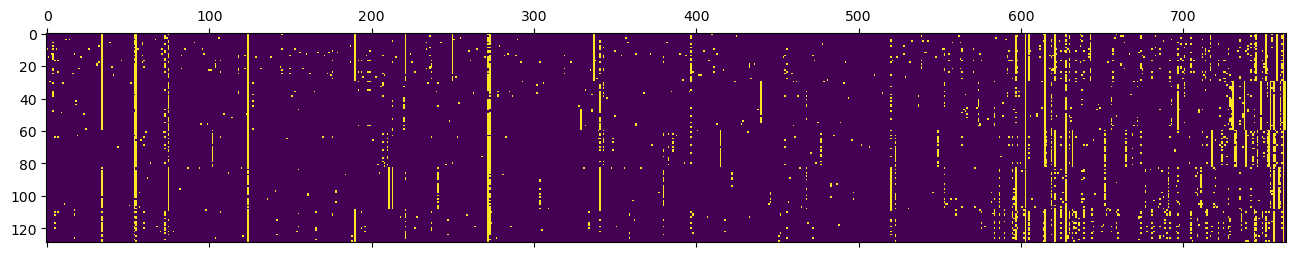

In [ ]:
plt.matshow(leuven_animal_array)

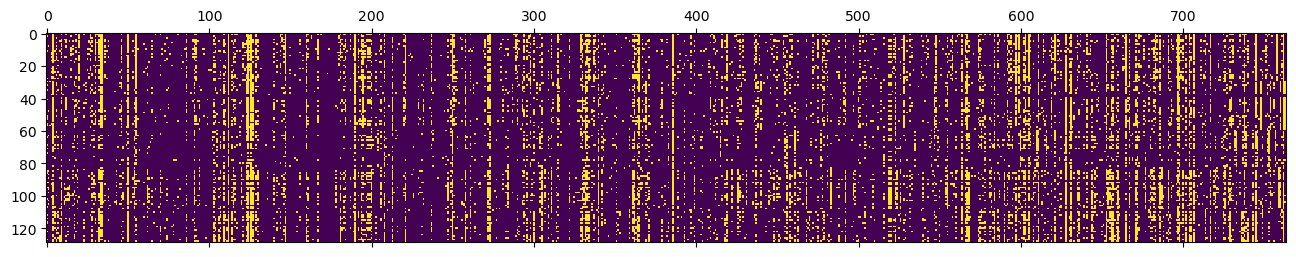

In [997]:
plt.matshow(flan_animal_array)

,concept,Harley_Davidson_is_a_brand,I_never_use_it,Indians_or_Afrikan,Jo_with_the_banjo,_in_the_morning,a_kind_of_thumbtack,a_synonym_is_'schuiftrompet',accompagnies_(other)_music,adores_sweetness,...,you_play_musical_notes_on_it,you_play_rhythms_on_it,you_put_butter_in_it,you_put_oil_in_it,you_ride_it_on_the_cycle_path,you_roast_meat_in_it,you_use_it_when_bricklaying,you_wear_it_in_your_shoes,you_wear_it_with_a_tie,zebra_crossing_(pedestrian-)
157,monkey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,beaver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,bison,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,dromedary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,squirrel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,paintbrush,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,file,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,level,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
212,saw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
### for flan df, don't change the order of the column 'concept' but reorder all the other columns based on the array feature_order



,concept,appears_in_comics,breeds_rapidly,builds_nests_at_high_altitude,"can_be_brown,_black,_white,_grey",can_be_fed,can_be_lethal_to_man,can_be_taught_tricks,can_eat_people,can_live_for_a_long_time_without_food,...,you_play_rhythms_on_it,you_put_butter_in_it,you_put_oil_in_it,you_ride_it_on_the_cycle_path,you_roast_meat_in_it,you_use_it_when_bricklaying,you_wear_it_in_your_shoes,you_wear_it_with_a_tie,you're_sitting_higher_in_it_than_in_a_car,you're_standing_with_1_leg_on_the_board
157,monkey,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16,beaver,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,bison,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,dromedary,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
242,squirrel,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,paintbrush,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,file,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,level,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
212,saw,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Greg's analyses

In [339]:
filename="leuven_data_set_numbers_only.mat"

In [340]:
leuven_array = loadmat(filename)
leuven_array = leuven_array['leuven_array']
leuven_array = leuven_array.astype(np.float)


In [341]:
(d1, d2) = leuven_array.shape

dropped_array = copy.deepcopy(leuven_array)
dropped_positive_count = 0
dropped_negative_count = 0


In [ ]:
#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1                

#   Matrix completion with IterativeSVD
#   -----------------------------------
#       -   we apply matrix completion to the partially masked matrix; the result has real-valued entries, which we round to 0/1
#       -   you can play with the rank parameter to get different results
#       -   as Tim predicted, higher ranks seem to support recovery of rows that have a higher degree of variation
#       -   the fancyimpute library has a range of other algorithms, in addition to IterativeSVD

dropped_array_partfilled = copy.deepcopy(dropped_array)
for iter in range(1):
    X_filled = IterativeSVD(min_value=0, max_value=1,rank=20).fit_transform(dropped_array_partfilled)
    X_guessed = np.round(X_filled)
    np.clip(X_guessed, 0, 1)

    for row in range(d1):
        for col in range(d2):
            if X_guessed[row][col] == 1:
                dropped_array_partfilled[row][col] = 1

#   Evaluate performance of the reconstruction procedure
#   ----------------------------------------------------

err_count = np.sum( np.round(X_guessed) != leuven_array )
pct_error = err_count / np.prod(leuven_array.shape)
pct_nonzero_true = np.count_nonzero(leuven_array) / np.product(leuven_array.shape)
pct_pos_correctly_identified = np.count_nonzero( (X_guessed == 1) & (leuven_array ==1) )/np.count_nonzero(leuven_array ==1)
pct_pos_previously_identified = np.count_nonzero(dropped_array == 1)/np.count_nonzero(leuven_array)
err_weighted = np.sum( np.abs( np.round(X_guessed) - leuven_array) )

err_count_above = np.sum( np.abs( np.round(X_guessed) > leuven_array) )
err_count_below = np.sum( np.abs( np.round(X_guessed) < leuven_array) )
# 10258.0
# 10395.0
# 10398

print("Let K    = number of entries in the matrix")
print("Let Kt   = number of positive entries in the matrix (ground truth)")
print("Let Kf   = number of negative entries in the matrix (ground truth)")
print("------------------------------------------------------------------")
print(f"masked positives                            {dropped_positive_count}        ")
print(f"masked negatives                            {dropped_negative_count}        ")
print(f"entries guessed incorrect (num)             {err_count}                     ")
print(f"entries guessed incorrect (num/K)           {pct_error}                     ")
print(f"Kt/K                                        {pct_nonzero_true}              ")
print(f"(# correct pos guess)/Kt                    {pct_pos_correctly_identified}  ")
print(f"(# correct pos not masked)/Kt               {pct_pos_previously_identified} ")
print(f"false positives                             {err_count_above}               ")
print(f"false negatives                             {err_count_below}               ")

# EXAMPLE OUTPUT:
# Let K    = number of entries in the matrix
# Let Kt   = number of positive entries in the matrix (ground truth)
# Let Kf   = number of negative entries in the matrix (ground truth)
# ------------------------------------------------------------------
# masked positives                            3660        
# masked negatives                            384155        
# entries guessed incorrect (num)             5430                     
# entries guessed incorrect (num/K)           0.006088187906369724                     
# Kt/K                                        0.042337012033981734              
# (# correct pos guess)/Kt                    0.9819650423728814  
# (# correct pos not masked)/Kt               0.903072033898305 
# false positives                             4749               
# false negatives                             681  


fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1 )
ax0.imshow( X_guessed, cmap='tab20_r', interpolation='nearest')
ax1.imshow( leuven_array, cmap='tab20_r', interpolation='nearest')
ax0.title.set_text('leuven (reconstructed)')
ax1.title.set_text('leuven')

fig.show()


In [ ]:
cors=[]
for i in range(leuven_animal_array.shape[0]):
    cors.append(np.corrcoef(leuven_animal_array[i,:],flan_animal_array[i,:])[0,1])
print(f'animal correlation: {np.mean(np.nan_to_num(cors,nan=0))}')

In [ ]:
### original code by Greg Henselman-Petrusek
### modified by Kushin Mukherjee